In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from math import sqrt

# Load data

In [3]:
!ls drive/MyDrive/SIT764/Property/data/

'add_feature (1).gsheet'	      'Geelong Properties - Final Data.csv'
 add_feature.csv		       old_completed_data.csv
 add_feature.gsheet		       old_subdata
 cleaning_data.csv		      'Property Record With Profile.csv'
 combined_data.csv		       suburb_data
'Final predicted average prices.csv'   Suburb_Profile.csv


In [4]:
folder_path = "drive/MyDrive/SIT764/Property/data/"
property_data = pd.read_csv(folder_path + 'cleaning_data.csv')
property_data.head()

,Suburb,Suburb_Code,Land Size SQM,Building Size SQM,Bedrooms,Toilets,Car,School,Shop,Restaurant,Station,Park,Hospital,Rent Amount PW,Auction,Last Sell Date,Last Sell Price,Sell Date,Sell Price
0,Armstrong Creek,1,539.0,176.000000,4.0,2.0,2.0,4,17,6,17,4,0,390.000000,0.0,2000-02-01,175000.0,2021-03-01,610000
1,Armstrong Creek,1,446.0,157.800253,4.0,2.0,2.0,5,9,7,14,3,0,800.847867,0.0,2019-04-01,545000.0,2021-03-01,645000
2,Armstrong Creek,1,398.0,161.000000,4.0,2.0,2.0,2,3,4,14,4,0,400.000000,0.0,2018-10-01,550000.0,2021-03-01,597500
3,Armstrong Creek,1,630.0,157.800253,4.0,2.0,4.0,2,4,4,14,3,0,800.847867,0.0,2014-03-01,207000.0,2021-03-01,841000
4,Armstrong Creek,1,449.0,170.000000,4.0,2.0,2.0,1,2,4,12,3,0,800.847867,0.0,2017-07-01,475000.0,2021-03-01,640000


# Pre-Processing data

In [ ]:
property_data = property_data.drop(["Suburb", "Last Sell Date", "Sell Date"], axis = 1)
property_data

,Suburb_Code,Land Size SQM,Building Size SQM,Bedrooms,Toilets,Car,School,Shop,Restaurant,Station,Park,Hospital,Rent Amount PW,Auction,Last Sell Price,Sell Price
0,1,539.0,176.000000,4.0,2.0,2.0,4,17,6,17,4,0,390.000000,0.0,175000.0,610000
1,1,446.0,157.800253,4.0,2.0,2.0,5,9,7,14,3,0,800.847867,0.0,545000.0,645000
2,1,398.0,161.000000,4.0,2.0,2.0,2,3,4,14,4,0,400.000000,0.0,550000.0,597500
3,1,630.0,157.800253,4.0,2.0,4.0,2,4,4,14,3,0,800.847867,0.0,207000.0,841000
4,1,449.0,170.000000,4.0,2.0,2.0,1,2,4,12,3,0,800.847867,0.0,475000.0,640000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10938,31,1405.0,157.800253,3.0,1.0,1.0,15,20,16,20,5,16,800.847867,0.0,150000.0,600000
10939,31,581.0,157.800253,4.0,2.0,4.0,14,20,16,20,5,16,800.847867,0.0,230000.0,375000
10940,31,645.0,122.000000,3.0,1.0,1.0,14,20,17,20,5,16,350.000000,0.0,178000.0,300000
10941,31,774.0,157.800253,3.0,1.0,4.0,11,20,20,20,1,13,290.000000,0.0,143000.0,255000


In [ ]:
property_data.describe()

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(y='Suburb_Code', data=property_data)

In [ ]:
property_data.corr()

In [ ]:
mask=np.zeros_like(property_data.corr())
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))
with sns.axes_style("white"):
    ax = sns.heatmap(property_data.corr()*100, mask=mask, fmt='.0f', annot=True, lw=1, cmap=ListedColormap(['green', 'yellow', 'red','blue']))

In [ ]:
cols = ['Suburb_Code', 'Land Size SQM', 'Building Size SQM', 'Bedrooms', 'School', 'Shop', 'Restaurant', 'Station', 'Park', 'Hospital', 'Rent Amount PW', 'Auction', 'Last Sell Price']
sns.pairplot(property_data[cols], size = 2.5)
plt.show();

In [ ]:
y = property_data["Sell Price"]
X =  property_data.drop(["Sell Price"], axis = 1)

In [ ]:
X.head()

,Suburb_Code,Land Size SQM,Building Size SQM,Bedrooms,Toilets,Car,School,Shop,Restaurant,Station,Park,Hospital,Rent Amount PW,Auction,Last Sell Price
0,1,539.0,176.000000,4.0,2.0,2.0,4,17,6,17,4,0,390.000000,0.0,175000.0
1,1,446.0,157.800253,4.0,2.0,2.0,5,9,7,14,3,0,800.847867,0.0,545000.0
2,1,398.0,161.000000,4.0,2.0,2.0,2,3,4,14,4,0,400.000000,0.0,550000.0
3,1,630.0,157.800253,4.0,2.0,4.0,2,4,4,14,3,0,800.847867,0.0,207000.0
4,1,449.0,170.000000,4.0,2.0,2.0,1,2,4,12,3,0,800.847867,0.0,475000.0


# Spit the whole data into the training set and test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
print(f"the number of sample in the train set is {X_train.shape[0]} sample")
print(f"the number of sample in the train set is {X_test.shape[0]} sample")

the number of sample in the train set is 8754 sample
the number of sample in the train set is 2189 sample


In [ ]:
s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test = s_scaler.transform(X_test.astype(np.float))

# Neural Network

In [ ]:
from tensorflow import keras
from datetime import datetime
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import time

In [ ]:
##Split training data into the trainning set and the validation test
X_train_sm, X_val, y_train_sm, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [ ]:
#Before training the model, some lists are create to store the infomation about model_name, dropout_rate, batch_normalisation, optimizer_style, learning_rate, number_of_epoch, val_accuracy, runningtime of the model.
#After that, one table will be created for model selection.
list_models = []
dropout_rates = []
batch_normalisations = []
optimizers = []
learning_rates = []
number_of_epochs = []
val_rmses = []
running_times = []

def store_model(model_name, dropout_rate, batch_normalisation, optimizer_style, learning_rate, number_of_epoch, val_rmse, running_time):
    list_models.append(model_name)
    dropout_rates.append(dropout_rate)
    batch_normalisations.append(batch_normalisation)
    optimizers.append(optimizer_style)
    learning_rates.append(learning_rate)
    number_of_epochs.append(number_of_epoch)
    val_rmses.append(val_rmse)
    running_times.append(running_time)

In [ ]:
#Plot function
def plot_performance(history):
  plt.plot(history.history['root_mean_squared_error'])
  plt.plot(history.history['val_root_mean_squared_error'])
  plt.title('RMER')
  plt.ylabel('RMER')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
#Built a new funtion to create new models
#The inputs are:
    #name: The name of model
    #drop_rate: None or one value from 0 to 1
    #batch_ormalisation: True or False
    #optimizer_style: the option of optimizer. {Adam, SGD, RMSprop}
    #learning_rate:the Learning Rate
    #num_epochs: the maximum number of epoches
    #stop_ealy: the number of patientive epoches to stop early

    
    
def new_model(name, dropout_rate, batch_normalisation, optimizer_style,learning_rate, num_epochs, stop_early):
    new_model = Sequential()
    new_model.add(Dense(128,input_dim=X_train_sm.shape[1], activation='relu'))

    # Add .Batch Normalization
    if batch_normalisation:
        new_model.add(layers.BatchNormalization())
    # Add drop out for Dense layer 1
    if dropout_rate:
        new_model.add(layers.Dropout(dropout_rate))
    
    #Dense layer 2
    new_model.add(layers.Dense(256, activation='relu'))
    # Add Batch Normalization for Dense layer 2
    if batch_normalisation:
        new_model.add(layers.BatchNormalization())
    # Add drop out for Dense layer 2
    if dropout_rate:
        new_model.add(layers.Dropout(dropout_rate))

    #Dense layer 3
    new_model.add(layers.Dense(128, activation='relu'))
    # Add Batch Normalization for Dense layer 3
    if batch_normalisation:
        new_model.add(layers.BatchNormalization())
    # Add drop out for Dense layer 3
    if dropout_rate:
        new_model.add(layers.Dropout(dropout_rate))

    #output layer
    new_model.add(Dense(1))
    
    print(f"The structure of {name}")
    new_model.summary()

    #Take optimizer
    if  optimizer_style == "Adam":
        optimizer = tf.keras.optimizers.Adam(lr = learning_rate)
    elif  optimizer_style == "SGD":
        optimizer = tf.keras.optimizers.SGD(lr = learning_rate, momentum = 0.9)
    elif  optimizer_style == "RMSprop":
        optimizer = tf.keras.optimizers.RMSprop(lr = learning_rate)
    
    #Stop early
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_early)

    #Save the weight of best model
    save_model = ModelCheckpoint(f'../content/bestmodel/{name}', monitor="val_root_mean_squared_error", verbose=0, save_best_only=True, mode='min')
    new_model.compile(optimizer=optimizer, loss='MSE',
              metrics = tf.keras.metrics.RootMeanSquaredError())
    num_epochs = 1000
    start_time = time.time()
    #Train the new model
    new_model_history = new_model.fit(
    x=X_train_sm,y=y_train_sm,
    epochs=num_epochs,
    batch_size = 64,
    validation_data = (X_val,y_val),
    callbacks=[stop_early, save_model])
    running_time = time.time() - start_time
    
    #Show the perfromance of model
    val_rmse= new_model_history.history["val_root_mean_squared_error"]
  
    mix_index = np.argmin(val_rmse)
    
    #Save the parameter of model
    store_model(name, dropout_rate, batch_normalisation, optimizer_style, learning_rate, mix_index+1,val_rmse[mix_index], running_time)

    #Plot the loss and accuracy on the trainning set and test set
    plot_performance(new_model_history)
    print(f"The best RMSE of {name} is {val_rmse[mix_index]} at epoch {mix_index+1}") 
    return new_model

The structure of neural_network_1
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 128)               2048      
_________________________________________________________________
dense_49 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_50 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 129       
Total params: 68,097
Trainable params: 68,097
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
110/110 [==============================] - 1s 5ms/step - loss: 445116663678.8469 - root_mean_squared_error: 666610.7821 - val_loss: 396309168128.0000 - val_root_mean_squared_error: 629530.9375
INFO:te

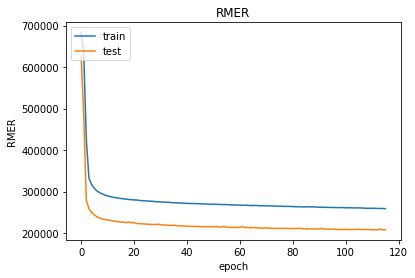

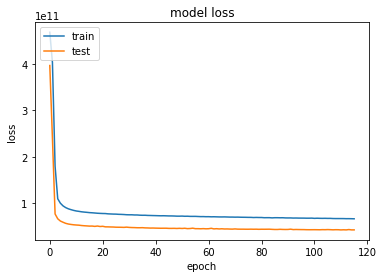

The best RMSE of neural_network_1 is 207536.1875 at epoch 111


In [ ]:
model_1 = new_model("neural_network_1", False, False, "Adam", 0.001, 1000, 5)

The structure of neural_network_2
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 128)               2048      
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
_________________________________________________________________
dense_53 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
dense_54 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_11 (Batc (None, 128)               512       
_________________________________________________________________
dense_55 (Dense)   

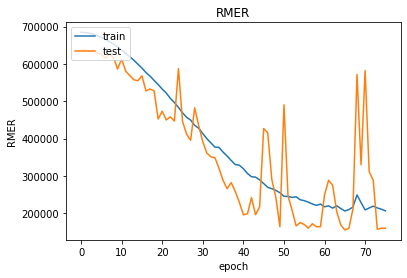

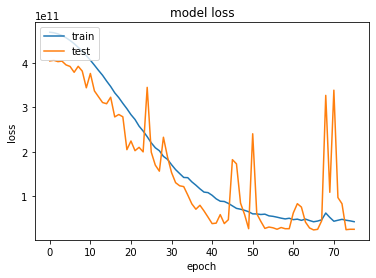

The best RMSE of neural_network_2 is 155559.234375 at epoch 66


In [ ]:
model_2 = new_model("neural_network_2", False, True,  "Adam", 0.01, 1000, 10)

The structure of neural_network_3
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 128)               2048      
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_58 (Dense)   

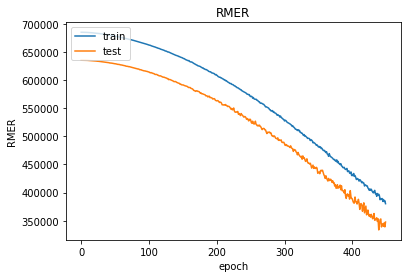

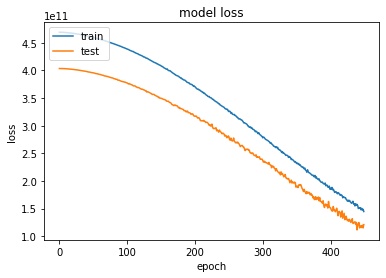

The best RMSE of neural_network_3 is 333674.59375 at epoch 440


In [ ]:
model_3 = new_model("neural_network_3", 0.6, True, "Adam", 0.001, 1000, 10)

The structure of neural_network_4
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 128)               2048      
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_63 (Dense)   

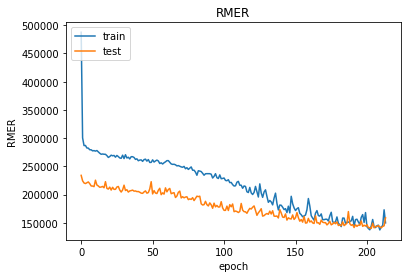

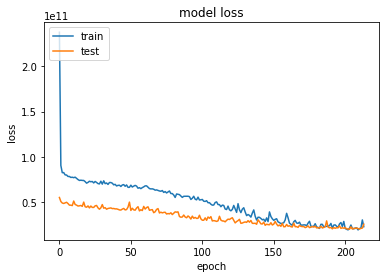

The best RMSE of neural_network_4 is 139916.625 at epoch 204


In [ ]:
model_4 = new_model("neural_network_4", 0.1, False, "Adam", 0.01, 1000, 10)

The structure of neural_network_5
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 128)               2048      
_________________________________________________________________
batch_normalization_15 (Batc (None, 128)               512       
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_66 (Dense)   

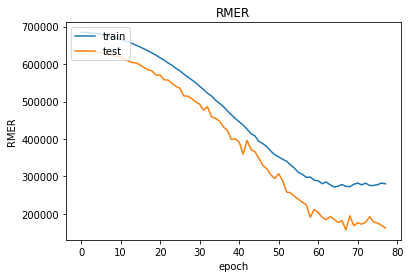

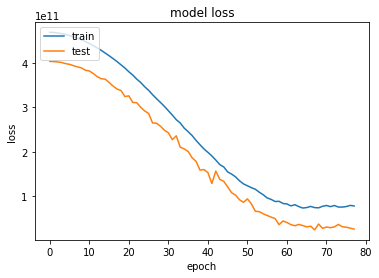

The best RMSE of neural_network_5 is 157383.0625 at epoch 68


In [ ]:
model_5 = new_model("neural_network_5", 0.5, True, "RMSprop", 0.01, 1000, 10)

The structure of neural_network_6
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 128)               2048      
_________________________________________________________________
batch_normalization_18 (Batc (None, 128)               512       
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_19 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_70 (Dense)   

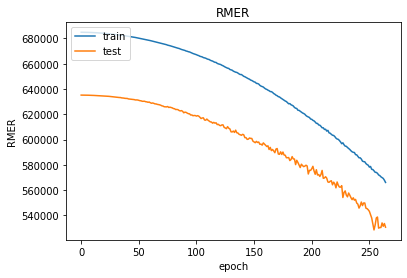

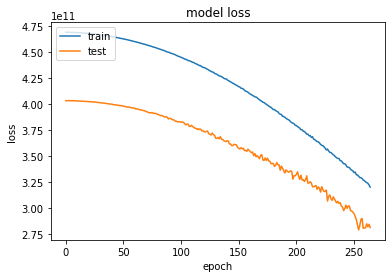

The best RMSE of neural_network_6 is 528565.8125 at epoch 255


In [ ]:
model_6 = new_model("neural_network_6", 0.3, True, "RMSprop", 0.001, 1000, 10)

The structure of neural_network_7
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 128)               2048      
_________________________________________________________________
batch_normalization_21 (Batc (None, 128)               512       
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_22 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_74 (Dense)   

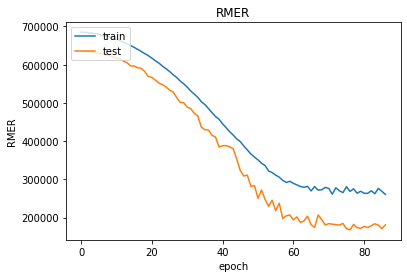

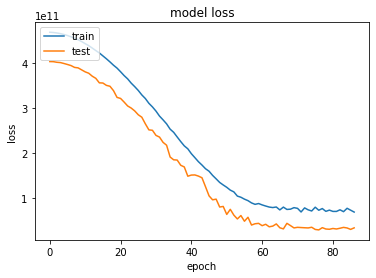

The best RMSE of neural_network_7 is 167628.484375 at epoch 77


In [ ]:
model_7 = new_model("neural_network_7", 0.5, True, "RMSprop", 0.01, 1000, 10)

The structure of neural_network_8
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 128)               2048      
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_79 (Dense)   

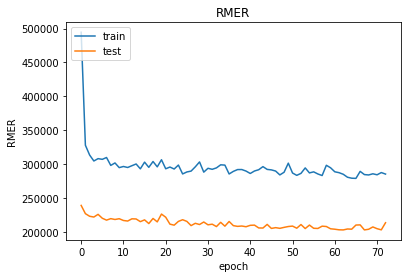

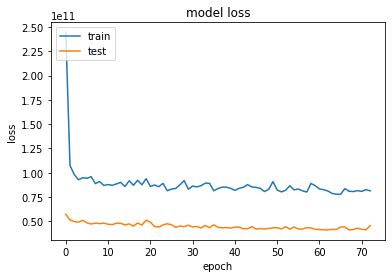

The best RMSE of neural_network_8 is 202674.921875 at epoch 63


In [ ]:
model_8 = new_model("neural_network_8", 0.5, False, "Adam", 0.01, 1000, 10)

The structure of neural_network_9
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 128)               2048      
_________________________________________________________________
batch_normalization_24 (Batc (None, 128)               512       
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_82 (Dense)   

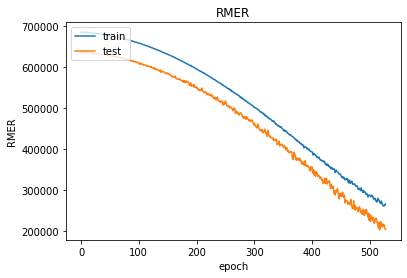

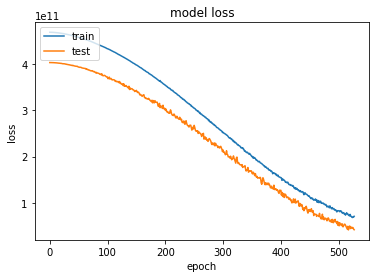

The best RMSE of neural_network_9 is 202753.171875 at epoch 518


In [ ]:
model_9 = new_model("neural_network_9", 0.2, True, "Adam", 0.001, 1000, 10)

The structure of neural_network_10
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 128)               2048      
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_25 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_87 (Dense)  

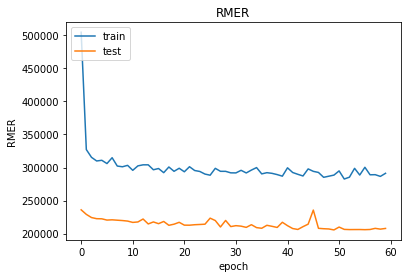

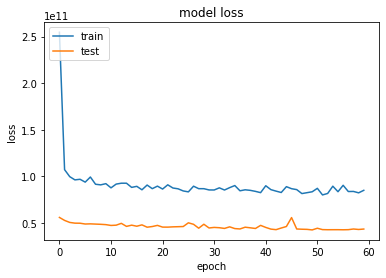

The best RMSE of neural_network_10 is 205617.203125 at epoch 50


In [ ]:
model_10 = new_model("neural_network_10", 0.5, False, "Adam", 0.01, 1000, 10)

The structure of neural_network_11
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 128)               2048      
_________________________________________________________________
batch_normalization_27 (Batc (None, 128)               512       
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_28 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_28 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_90 (Dense)  

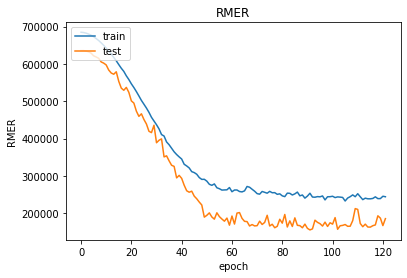

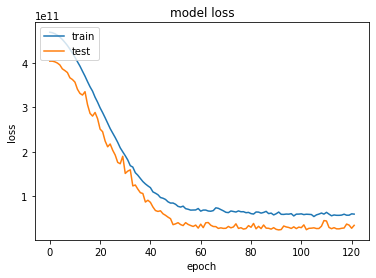

The best RMSE of neural_network_11 is 155514.515625 at epoch 92


In [ ]:
model_11 = new_model("neural_network_11", 0.4, True, "Adam", 0.01, 1000, 30)

The structure of neural_network_12
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 128)               2048      
_________________________________________________________________
batch_normalization_30 (Batc (None, 128)               512       
_________________________________________________________________
dropout_30 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_31 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_31 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_94 (Dense)  

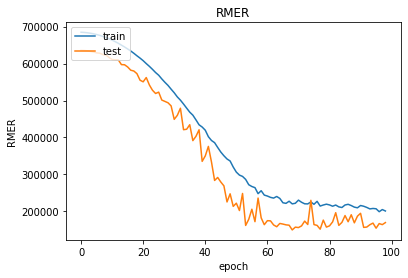

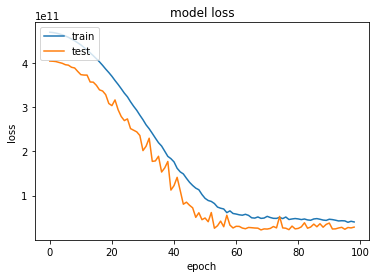

The best RMSE of neural_network_12 is 149671.890625 at epoch 69


In [ ]:
model_12 = new_model("neural_network_12", 0.1, True, "RMSprop", 0.01, 1000, 30)

The structure of neural_network_13
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 128)               2048      
_________________________________________________________________
batch_normalization_33 (Batc (None, 128)               512       
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_97 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_34 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_34 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_98 (Dense)  

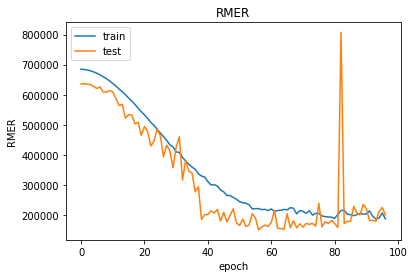

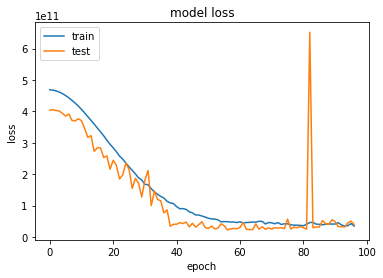

The best RMSE of neural_network_13 is 150715.703125 at epoch 57


In [ ]:
model_13 = new_model("neural_network_13", 0.01, True, "Adam", 0.01, 1000, 40)

The structure of neural_network_14
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 128)               2048      
_________________________________________________________________
batch_normalization_36 (Batc (None, 128)               512       
_________________________________________________________________
dropout_36 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 256)               33024     
_________________________________________________________________
batch_normalization_37 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_37 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_102 (Dense) 

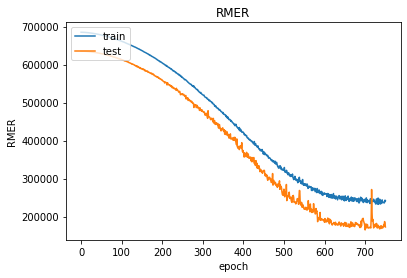

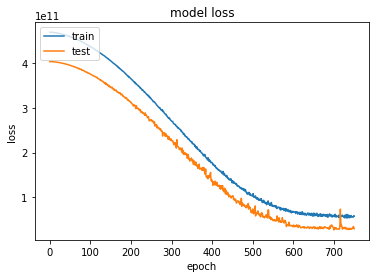

The best RMSE of neural_network_14 is 164691.5625 at epoch 701


In [ ]:
model_14 = new_model("neural_network_14", 0.5, True, "Adam", 0.001, 1000, 50)

The structure of neural_network_15
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_104 (Dense)            (None, 128)               2048      
_________________________________________________________________
batch_normalization_39 (Batc (None, 128)               512       
_________________________________________________________________
dropout_39 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_105 (Dense)            (None, 256)               33024     
_________________________________________________________________
batch_normalization_40 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_40 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_106 (Dense) 

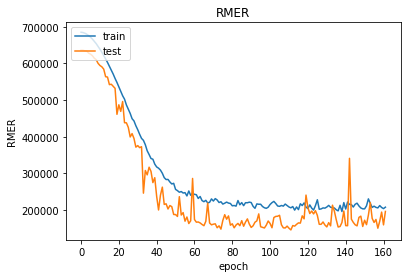

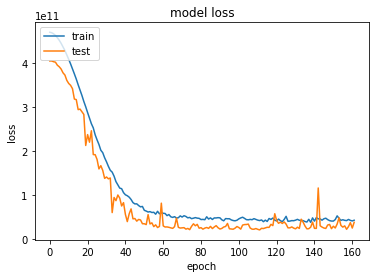

The best RMSE of neural_network_15 is 145660.46875 at epoch 112


In [ ]:
model_15 = new_model("neural_network_15", 0.1, True, "Adam", 0.01, 1000, 50)

In [ ]:
table = pd.DataFrame([])
table["Model"] = list_models
table["Dropout (rate)"] = dropout_rates
table["Batch Normalisation (Y/N)"] = batch_normalisations
table["Optimizer"] = optimizers
table["Learning Rate"] = learning_rates
table["Number of Epochs"] = number_of_epochs
table["Running time (s)"] = running_times
table["RMSE"] = val_rmses 
table  = table.fillna(0)
table

,Model,Dropout (rate),Batch Normalisation (Y/N),Optimizer,Learning Rate,Number of Epochs,Running time (s),RMSE
0,neural_network_1,False,False,Adam,0.001,111,101.753902,207536.187500
1,neural_network_2,False,True,Adam,0.010,66,98.516062,155559.234375
2,neural_network_3,0.6,True,Adam,0.001,440,973.945852,333674.593750
3,neural_network_4,0.1,False,Adam,0.010,204,175.888315,139916.625000
4,neural_network_5,0.5,True,RMSprop,0.010,68,174.748575,157383.062500
5,neural_network_6,0.3,True,RMSprop,0.001,255,531.318402,528565.812500
6,neural_network_7,0.5,True,RMSprop,0.010,77,182.055611,167628.484375
7,neural_network_8,0.5,False,Adam,0.010,63,64.802504,202674.921875
8,neural_network_9,0.2,True,Adam,0.001,518,916.927178,202753.171875
9,neural_network_10,0.5,False,Adam,0.010,50,53.322357,205617.203125


Assign the best model among 15 models

In [ ]:
min_mae = np.argmin(val_rmses)
print(f"The best model is {list_models[min_mae]} with the Mean Absolote Error is {min(val_rmses)}")

The best model is neural_network_4 with the Mean Absolote Error is 139916.625


# Evaluate the model

Load the best model

In [ ]:
final_model =tf.keras.models.load_model(f'../content/bestmodel/{list_models[min_mae]}/')
print("the structure of the final model")
final_model.summary()

the structure of the final model
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 128)               2048      
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_63 (Dense)    

The final model has 3 layers with 128, 256, and 128 nodes, respectively.

The dropout rate for each layer is 0.1. Additionaly, it contains 3 batch normalization layers.

The optimizer is Adam with the learning rate is 0.01.

The model was fitted 204 epochs.

In [ ]:
y_pred = final_model.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0])

y_pred = [i for i in y_pred]

In [ ]:
#calculate the MAE and RMSE

MAE = metrics.mean_absolute_error(y_test, y_pred)
print(f"mean absolute error (MAE): {round(MAE,2)} dollars")
RMSE =  sqrt(mse(y_test, y_pred))
print(f"Root mean squared error: {round(RMSE,2)} dollars")

mean absolute error (MAE): 76531.0 dollars
Root mean squared error: 151609.0 dollars


| Model | MAE | RMSE |
| --- | --- | --- |
| Model T1 2021 |  76531 |  151609 |
| Model T2 2020 |  95865 |  204316 |

# Save model

In [ ]:
!ls drive/MyDrive/SIT764/Property/model/

In [ ]:
final_model.save(f"drive/MyDrive/SIT764/Property/model/model_1")

INFO:tensorflow:Assets written to: drive/MyDrive/SIT764/Property/model/model_1/assets
